# Data Pipelines with TensorFlow

**Objectives**
- How to make pipelines with Deep Learning
- How to load heavy data batch per batch

# Part I: How to make pipelines with Deep Learning

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf

## Load data

Let's load the **PetFinder** dataset. Each row describes a pet, and each column describes an attribute.  
You will use this information to **predict if the pet will be adopted**. 

<details>
    <summary>Below is a description of this dataset.
</summary>

Column | Description| Feature Type | Data Type
------------|--------------------|----------------------|-----------------
Type | Type of animal (Dog, Cat) | Categorical | string
Age |  Age of the pet | Numerical | integer
Breed1 | Primary breed of the pet | Categorical | string
Color1 | Color 1 of pet | Categorical | string
Color2 | Color 2 of pet | Categorical | string
MaturitySize | Size at maturity | Categorical | string
FurLength | Fur length | Categorical | string
Vaccinated | Pet has been vaccinated | Categorical | string
Sterilized | Pet has been sterilized | Categorical | string
Health | Health Condition | Categorical | string
Fee | Adoption Fee | Numerical | integer
Description | Profile write-up for this pet | Text | string
PhotoAmt | Total uploaded photos for this pet | Numerical | integer
AdoptionSpeed | Speed of adoption | Classification | integer
</details>

In [0]:
dataframe = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/petfinder.csv")
dataframe

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

In [0]:
X_train = train.drop(columns='target')
y_train = train['target']

X_val = val.drop(columns='target')
y_val = val['target']

X_test = test.drop(columns='target')
y_test = test['target']

☝️ Our dataset comprises of both Numerical and Categorical values. We need to preprocess them before feeding into a Neural Network.

You have three options:

**A**. Use sklean to preprocess data before feeding a neural network (no pipelines)  
**B**. Wrap your neural network into a sklearn estimator (pipelines)  
**C**. Use full Tensorflow pipelines  

## A. Use sklean to preprocess data before feeding a neural network (no pipelines)

#### Preprocessing
❓ Create a `X_train_preproc`, `X_val_preproc`, `X_test_preproc` scaling numerical data and One Hot Encoding categorical one

In [0]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector

In [0]:
# YOUR CODE HERE

#### Neural Network

❓ Fit a Neural Network and evaluate its performance on the test set 

In [0]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
# YOUR CODE HERE

## B. Wrap your neural network into a sklearn estimator & pipelines

We can actually treat a Keras model as a scikit-learn estimator, using [Keras Wrappers](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn)  
It allows us to place the estimator inside a sklearn pipeline and include preprocessing inside. We can even gridsearch hyper-params.

❓Run the cells below to undersand the syntax

In [0]:
def create_model():
    
    # Define architecture without input shape yet, as we don't know the shape post preprocessing
    model = Sequential()
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, 
                        epochs=10, 
                        batch_size=32, 
                        verbose=0)

❓ Evaluate - or rather cross-validate - your estimator on your training set already preprocessed

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
# YOUR CODE HERE

❓ Wrap your model inside a pipeline including preprocessing and evaluate it directly on the raw data this time

In [0]:
from sklearn.pipeline import make_pipeline

In [0]:
# YOUR CODE HERE

#### GridSearch CV on the pipeline!

Now that our model is pipelined, we can even grid_searched its hyper-parameters

❓ Run the cells below to understand how the syntax works

In [0]:
def create_model_grid(activation = 'relu', 
                      optimizer='rmsprop'):
    # create model
    model = Sequential()
    model.add(layers.Dense(32, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(15, activation=activation))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

In [0]:
model_grid = KerasClassifier(
    build_fn=create_model_grid,
    epochs=10,
    batch_size=32,
    verbose=0,
)

In [0]:
pipe_grid = make_pipeline(preproc, model_grid)
#pipe_grid.get_params()

In [0]:
# Now, we can gridsearch the hyper-params of everything
# From the preprocessing, the architecture, the compiler, and the fit!

from sklearn.model_selection import GridSearchCV

param_grid = dict(
    columntransformer__standardscaler__with_mean=[True, False], # Preprocessing hyperparams
    kerasclassifier__activation=['tanh', 'relu'], # Architecture hyperparams
    kerasclassifier__optimizer=["adam", "rmsprop"], # Compiler hyperparams
    kerasclassifier__batch_size=[8, 64], # Fit hyperparams
)

grid = GridSearchCV(estimator=pipe_grid,
                    param_grid=param_grid,
                    cv=2,
                    verbose=2,
                    n_jobs=-1)

In [0]:
grid.fit(X_train, y_train);

In [0]:
grid.best_params_

In [0]:
grid.best_score_

In [0]:
cross_val_score(grid.best_estimator_, X_train, y_train)

## Option C: Full pipeline in Tensorflow

This option is recommended for real projects, especially when you need (i) performance or (ii) production-readiness


<details>
    <summary>Why?</summary>

Indeed, having all preprocessing inside one single TensorFlow Keras model allows to generate one [`tf.Graph`](https://www.tensorflow.org/guide/intro_to_graphs) representation of your model, which is mandatory for distributed computation and serving on many devices (using Tensorflow Lite for back-end-free predictions for instance). 
</details>

The idea is to use **Normalization** and **CategoryEncoding** layers within your model architecture.

### 😌 If the preproc pipeline is sequential, everything is easy

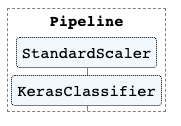

For instance, if there were only numerical data on our dataset:

In [0]:
# Imagine we only have numerical data to scale
X_train_num = X_train.select_dtypes(exclude=['object']).values
X_val_num = X_val.select_dtypes(exclude=['object']).values
X_test_num = X_test.select_dtypes(exclude=['object']).values

In [0]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization

normalizer = Normalization() # Instantiate a "normalizer" layer
normalizer.adapt(X_train_num) # "Fit" it on the train set

model = Sequential()
model.add(normalizer) # Use it as first sequential step
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3a))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.fit(X_train_num,
          y_train,
          validation_data=(X_val_num, y_val),
          batch_size=64,
          epochs=20, verbose=0)

model.evaluate(X_test_num, y_test)

### 🤯 if the preproc pipeline requires parallel column transformers, TF Sequential API `model.add(...)` is not enough 

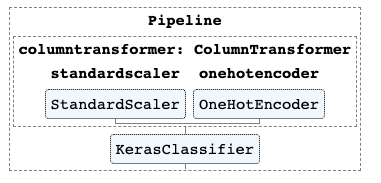

☝️ You will need to use TF **Fonctional API** to produce a non-sequential Neural Network

Don't worry: you **will** be able to learn how to build such models if you want.

📚 [Google's Tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) show you how to solve this exact PetFinder dataset with this method

Non-sequential models look something like:

```python
# Numerical preprocessing model = function(X_numerical)
model_numerical = ...  

# Categorical preprocessing model = function(X_categorical)
model_categorical = ...

# Combined model
all_features = layers.concatenate([model_numerical, model_categorical])

# Then create the Dense network on the preprocessed features
x = tf.keras.layers.Dense(8, activation="relu")(all_features)
x = tf.keras.layers.Dense(2, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

model.compile(...)
```

<img src='https://github.com/lewagon/data-images/blob/master/DL/non_sequential_models.png?raw=true' width=400>

---

# Part II. How to deal with heavy datasets?

⚠️ Most Deep Learning project uses data **too heavy to be loaded on RAM entirely**  
  Fortunately, we only have to train our network **batch per batch**!

✅ Tensorflow provides a powerful [`tf.data.Dataset`]() class that help to deal with it data loading and processing batch-per-batch

✅ Keras provides cool [`tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) wrappers around this to avoid getting your hand too dirty:
- `image_dataset_from_directory`
- `text_dataset_from_directory`
- `timeseries_dataset_from_array`

Let's illustrate this with a heavy images datasets

### 1. Save large files on a hard drive (local or cloud)

❓ Run following cells (never mind the syntax)

In [0]:
! pip install -U --quiet tensorflow_datasets Pillow

In [0]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

In [0]:
# We download 229Mo of images

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [0]:
# We just unzipped and saved all these file in the following folder 
data_dir

In [0]:
# Notice how each photo is saved in a different folder depending on its category
! ls $data_dir

In [0]:
# In total we have 229Mo of files, compressed.
# Imagine they were 50Go ? They couldn't fit in RAM
! du -h $data_dir

In [0]:
# We have 3670 jpg images in 5 classes
len(list(data_dir.glob('*/*.jpg')))

In [0]:
# Just look at one image
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

### 2. Prepare to load images in RAM memory batch per batch 

We will use `image_dataset_from_directory`

In [0]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [0]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  batch_size=32)

☝️ Notice how it automatically labels data into the 5 class!
- By default, `labels='inferred'` from the folder structure
- You can pass a list of labels manually with a list integer

In [0]:
# `ds` is a `tf.data.Dataset` object of "tuples"
ds

In [0]:
# Dataset contain no real data until they are iterated over 
import sys
sys.getsizeof(ds)

In [0]:
for (X_batch, y_batch)  in ds:
    print(X_batch.shape)
    print(y_batch.shape)
    
    break # just show the first element

In [0]:
# check first image
plt.imshow(X_batch[0]/255);

`tf.data.Dataset` are just an abstraction that represents a sequence of elements. They allow to

- Load elements batch-per-batch in memory
- From different formats, storage places, etc...
- Apply preprocessing on the fly (ex: shuffle, resize, and many many more)

📚 [TF Guide on data](https://www.tensorflow.org/guide/data)

### Train a model directly on a `Dataset`

❓ Try to fit a very simple dense NN on `ds` 

- You can directly call `model.fit(ds, epochs=1)`
- Your first layer should use `layers.Flatten` to flatten a (256,256,3) picture in into a (256 * 256 * 3,) vector so acceptable for Dense layers
- You can use `loss='sparse_categorical_crossentropy'`: "sparse_" avoids one-hot-encoding the target with `to_categorical(y)`


In [0]:
# YOUR CODE HERE

💡 Accuracy is no better than random because such Dense model architecture is not fitted to the task

In next session, we will use **convolutional neural networks (CNN)**

### (bonus) Proper solution to the flower problem using CNN & early stopping

In [0]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64), # resize on the fly
    batch_size=32)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64), # resize on the fly
    batch_size=32)

In [0]:
model = tf.keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1. / 255))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[EarlyStopping(patience=0)]
)

🏁 **Congratulation** 🏁